In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage.transform import resize
from PIL import Image
from datetime import datetime
import time

import os
import random
import shutil
import glob
import cv2
from glob import glob
import numpy as np
import pandas as pd
import gc
import pickle

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
def load_data(img_height, img_width, images_to_be_loaded):
    IMAGES_PATH = "Kvasir-SEG/images/"
    MASKS_PATH = "Kvasir-SEG/masks/"

    train_ids = glob(IMAGES_PATH + "*.jpg")

    train_ids = sorted(train_ids)

    if images_to_be_loaded == -1:
        images_to_be_loaded = len(train_ids)

    #Create Empty arrays to store data image.
    X = np.zeros((images_to_be_loaded, img_height, img_width, 3), dtype=np.float32)
    Y= np.zeros((images_to_be_loaded, img_height, img_width), dtype=np.uint8)

    print('Resizing training images and masks: ' + str(images_to_be_loaded))
    #Iterate over and load the corresponding image and mask
    for n, id_ in tqdm(enumerate(train_ids)):
        if n == images_to_be_loaded:
            break

        image_path = id_
        mask_path = image_path.replace("images", "masks")

        image = imread(image_path)
        mask_ = imread(mask_path)

        mask = np.zeros((img_height, img_width), dtype=np.bool_)

        pillow_image = Image.fromarray(image)

        #Resize the image
        pillow_image = pillow_image.resize((img_height, img_width))
        image = np.array(pillow_image)

        #Normalize the pixel values
        X[n] = image / 255

        pillow_mask = Image.fromarray(mask_)
        pillow_mask = pillow_mask.resize((img_height, img_width), resample=Image.LANCZOS)
        mask_ = np.array(pillow_mask)

        #Convert mask into binary array based on the threshold
        for i in range(img_height):
            for j in range(img_width):
                if np.any(mask_[i, j] >= 127):
                    mask[i, j] = 1
        #Store mask data
        Y[n] = mask
    #Expand dimension of mask array
    Y = np.expand_dims(Y, axis=-1)

    return X, Y

In [ ]:
class MyDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        """
        Args:
            images (numpy array): Array of images.
            masks (numpy array): Corresponding segmentation masks.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Convert to tensors
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Change to (C, H, W)
        mask = torch.tensor(mask, dtype=torch.float32)  # Mask should be (H, W, 1)

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)

        return image, mask

In [10]:
img_height, img_width = 256, 256  # Example size
images_to_be_loaded = -1  # Load all images

X, Y = load_data(img_height, img_width, images_to_be_loaded)

Resizing training images and masks: 1000


1000it [05:05,  3.27it/s]


In [11]:
dataset = MyDataset(X, Y)

# Create a DataLoader for batch processing
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example usage: Iterate through the DataLoader
for batch in dataloader:
    images, masks = batch
    print(images.shape, masks.shape)  # Should output: (batch_size, 3, H, W) and (batch_size, H, W, 1)
    break  # Just to check one batch

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256, 1])


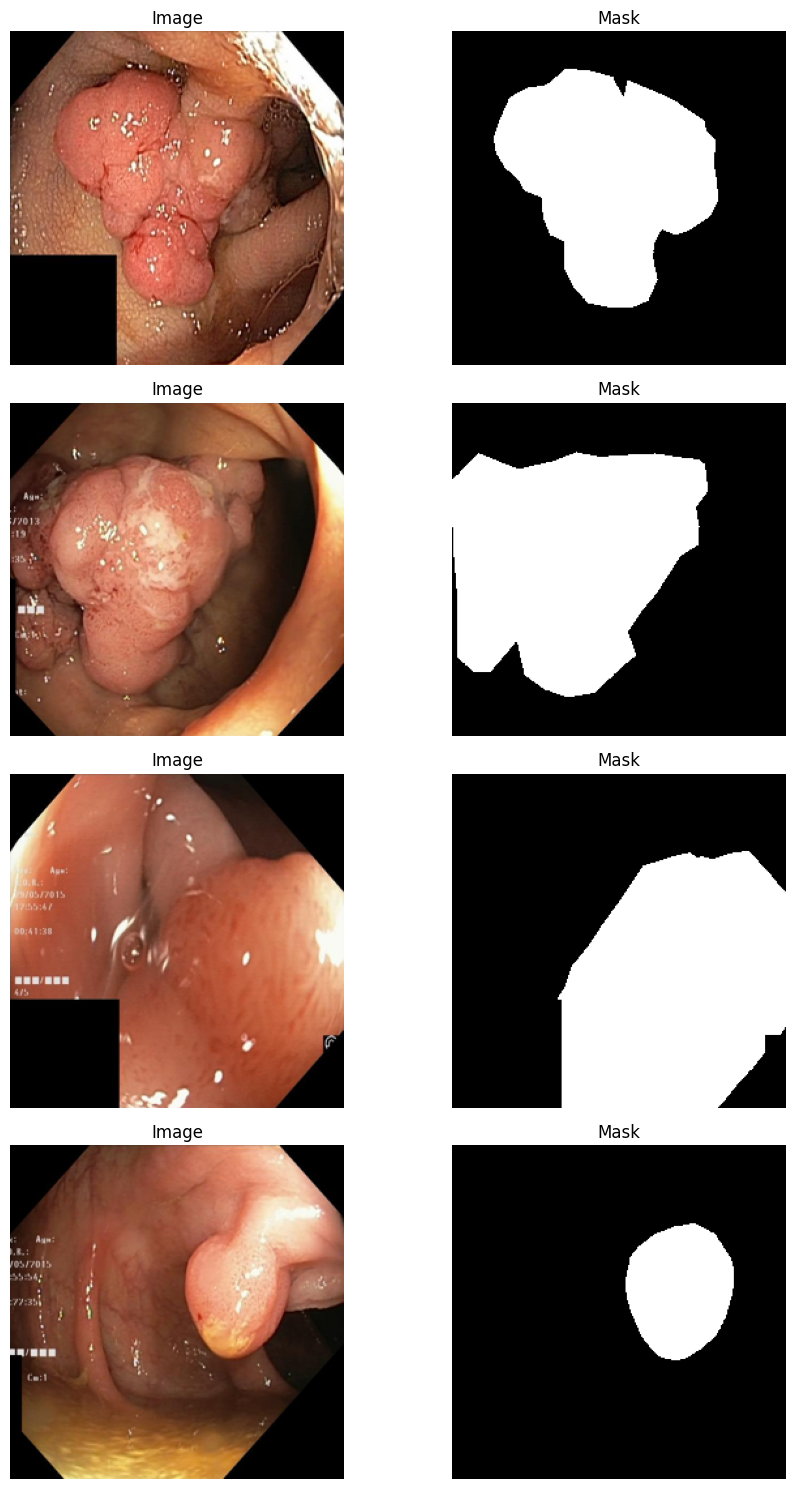

In [12]:
# Get a batch of data
batch = next(iter(dataloader))
images, masks = batch

# Convert tensors to NumPy for visualization
images = images.permute(0, 2, 3, 1).numpy()  # Convert from (B, C, H, W) -> (B, H, W, C)
masks = masks.squeeze(-1).numpy()  # Remove last dimension if it's (B, H, W, 1)

# Plot the first 4 images and their masks
fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for i in range(4):  # Display 4 samples
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title("Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(masks[i], cmap="gray")
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()
